In [ ]:
from google.colab import files
uplaod = files.upload()


Saving Temp_and_rain.csv to Temp_and_rain.csv


In [ ]:
import pandas as pd
data = pd.read_csv('Temp_and_rain.csv')
data_baru = data.drop(columns=['Month','Year'])
data_baru.head()
# from sklearn  import preprocessing
# scaler = preprocessing.StandardScaler().fit(data_baru)
# data_baru = scaler.transform(data_baru)
# data_baru

,tem,rain
0,16.9760,18.5356
1,19.9026,16.2548
2,24.3158,70.7981
3,28.1834,66.1616
4,27.8892,267.2150


In [ ]:
import numpy as np
from keras.layers import Dense, LSTM
temp = data_baru['tem'].values
label = data_baru['rain'].values

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

from sklearn.model_selection import train_test_split
temp_latih, temp_test, label_latih, label_test = train_test_split(temp, label, test_size=0.2, shuffle=False)

threshold_mae = (temp.max() - temp.min()) * 10/100
print(threshold_mae)

import tensorflow as tf
train_set = windowed_dataset(temp_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(50, return_sequences=True),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nMAE < 10% dataset!")
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_set,validation_data = (test_set),epochs=100, callbacks=[callbacks], verbose=2)

1.27254


Epoch 1/100
11/11 - 9s - loss: 20.3919 - mae: 20.8914 - val_loss: 7.7960 - val_mae: 8.2960 - 9s/epoch - 783ms/step
Epoch 2/100
11/11 - 2s - loss: 7.4085 - mae: 7.8981 - val_loss: 3.9940 - val_mae: 4.4842 - 2s/epoch - 214ms/step
Epoch 3/100
11/11 - 2s - loss: 4.5469 - mae: 5.0252 - val_loss: 2.7932 - val_mae: 3.2836 - 2s/epoch - 166ms/step
Epoch 4/100
11/11 - 2s - loss: 3.7962 - mae: 4.2751 - val_loss: 3.6271 - val_mae: 4.1162 - 2s/epoch - 145ms/step
Epoch 5/100
11/11 - 1s - loss: 3.1971 - mae: 3.6747 - val_loss: 2.3629 - val_mae: 2.8206 - 1s/epoch - 126ms/step
Epoch 6/100
11/11 - 1s - loss: 2.9438 - mae: 3.4158 - val_loss: 2.3707 - val_mae: 2.8474 - 1s/epoch - 123ms/step
Epoch 7/100
11/11 - 1s - loss: 2.8635 - mae: 3.3299 - val_loss: 2.8850 - val_mae: 3.3705 - 1s/epoch - 124ms/step
Epoch 8/100
11/11 - 3s - loss: 2.6866 - mae: 3.1499 - val_loss: 2.5865 - val_mae: 3.0751 - 3s/epoch - 260ms/step
Epoch 9/100
11/11 - 3s - loss: 2.5712 - mae: 3.0334 - val_loss: 2.4183 - val_mae: 2.8992 - 3s/

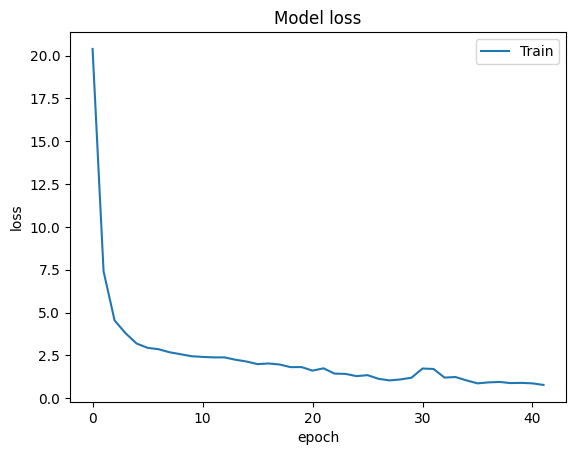

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

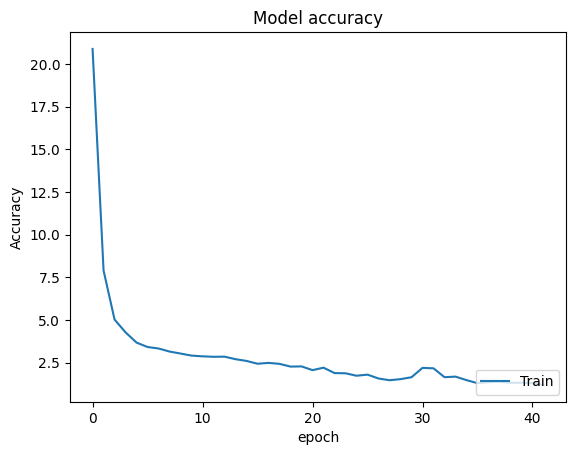

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train'], loc='lower right')
plt.show()